In [1]:
%matplotlib inline
import nba_py as nba
from nba_py import player
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import math

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

/Users/andrewzhuang/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [56]:
df = pd.read_csv('aug4.csv')
del df['Unnamed: 0']

In [9]:
to_predict = ['CT_W_PCT', 'CT_FG_PCT', 'CT_FGA',
       'CT_FG3_PCT', 'CT_FG3A', 'CT_FT_PCT','PO_FG_PCT', 'PO_FG3_PCT', 'PO_FT_PCT', 'PO_OREB', 'PO_DREB', 'PO_REB',
       'PO_AST', 'PO_TOV', 'PO_STL', 'PO_BLK', 'SC_FG_PCT', 'SC_FG3_PCT',
       'SC_FT_PCT', 'SC_OREB', 'SC_DREB', 'SC_REB', 'SC_AST', 'SC_TOV',
       'SC_STL', 'SC_BLK']

In [10]:
df_target = df[['CT_W_PCT', 'CT_FG_PCT', 'CT_FGA',
       'CT_FG3_PCT', 'CT_FG3A', 'CT_FT_PCT','PO_FG_PCT', 'PO_FG3_PCT', 'PO_FT_PCT', 'PO_OREB', 'PO_DREB', 'PO_REB',
       'PO_AST', 'PO_TOV', 'PO_STL', 'PO_BLK', 'SC_FG_PCT', 'SC_FG3_PCT',
       'SC_FT_PCT', 'SC_OREB', 'SC_DREB', 'SC_REB', 'SC_AST', 'SC_TOV',
       'SC_STL', 'SC_BLK']]
df_train = df.drop(to_predict, axis = 1, inplace = False)

In [26]:
#Making int values for categorical features/object items

def column_dict(column_values):
    my_dict = {}
    for i in range(len(column_values)):
        my_dict[column_values[i]] = i
    return (my_dict)
        
def to_numeric(x, col_dict):
    return (col_dict[x])

for col in df_train.dtypes[df_train.dtypes == object].index.values:
    col_d = column_dict(df_train[col].unique())
    df_train[col] = df_train[col].apply(lambda x: to_numeric(x, col_d))                        

In [55]:
#Set target column
targ_col = 'CT_FG_PCT'
df_train[targ_col] = df_target[targ_col]
df_train['TARGET'] = df_train['FG_PCT'] - df_train[targ_col]
del df_train[targ_col]

In [57]:
#Only predict for relevant columns
new_train = df_train[~df_train['TARGET'].isnull()]
new_train = new_train.fillna(-1)

In [73]:
new_train = new_train[new_train['GP'] > 40]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(new_train.drop('TARGET',axis=1,inplace=False),
                                                    new_train['TARGET'], test_size=0.33, random_state=0)

In [75]:
from xgboost import XGBRegressor

estimator = XGBRegressor(n_estimators=150)
estimator.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [82]:
df_results = pd.DataFrame()
df_results['prediction'] = estimator.predict(X_test)
df_results['actual'] = y_test.values
df_results['abs_error'] = abs(df_results['actual'] - df_results['prediction'])
df_results['error'] = df_results['actual'] - df_results['prediction']
df_results['pct_error'] = df_results['abs_error']/df_results['actual']

In [77]:
df_results['abs_error'].mean()

0.17120248381067843

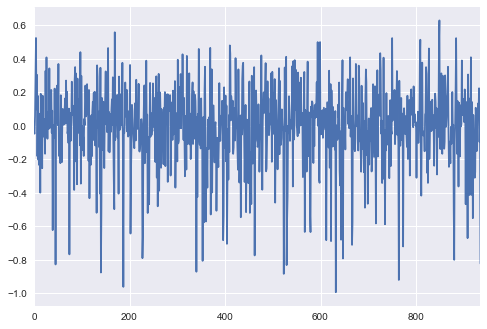

In [83]:
df_results['error'].plot()

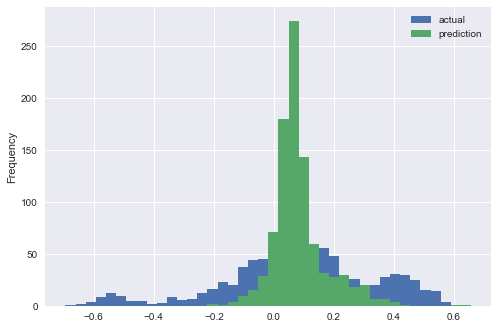

In [81]:
df_results[['actual','prediction']].plot(kind = 'hist', bins = 40)

In [66]:
df_results

,prediction,actual,abs_error,pct_error
0,-0.023109,0.118,0.141109,1.195837
1,0.363172,0.468,0.104828,0.223992
2,0.292591,0.354,0.061409,0.173473
3,0.114508,0.104,0.010508,0.101036
4,0.018111,0.152,0.133889,0.880852
5,0.673197,0.643,0.030197,0.046963
6,0.123271,0.139,0.015729,0.113156
7,-0.005760,0.146,0.151760,1.039453
8,0.139144,0.503,0.363856,0.723372
9,0.054358,0.108,0.053642,0.496683


In [53]:
new_train

,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,...,LAY_FG_PCT,TIP_FGA,TIP_FG_PCT,SCHOOL,HEIGHT,WEIGHT,POSITION,DRAFT_NUMBER,CT_FG_PCT,TARGET
0,0.445000,0.382000,0.846000,0.200000,1.400000,1.600000,2.500000,1.600000,0.700000,0.100000,...,-1.000,-1.0,-1.000,0,0,162,0,3,0.486,-0.041000
1,0.377000,0.161000,1.000000,0.200000,1.000000,1.200000,1.900000,0.600000,0.500000,0.000000,...,-1.000,-1.0,-1.000,0,0,162,0,3,0.000,0.377000
3,0.403000,0.211000,0.672000,0.700000,1.200000,2.000000,0.900000,1.100000,0.600000,0.200000,...,-1.000,-1.0,-1.000,1,1,235,1,11,0.333,0.070000
4,0.435000,0.286000,0.691000,1.500000,2.300000,3.800000,1.000000,1.400000,1.000000,0.300000,...,-1.000,-1.0,-1.000,1,1,235,1,11,0.667,-0.232000
5,0.415333,0.241667,0.752000,1.666667,2.833333,4.500000,1.633333,1.633333,0.866667,0.533333,...,-1.000,-1.0,-1.000,1,1,235,1,11,0.333,0.082333
9,0.453000,0.259000,0.746000,2.700000,4.200000,6.900000,2.200000,2.800000,1.000000,1.000000,...,-1.000,-1.0,-1.000,2,2,245,2,3,0.500,-0.047000
10,0.484000,0.412000,0.784000,2.800000,4.300000,7.100000,2.600000,3.100000,1.100000,0.900000,...,-1.000,-1.0,-1.000,2,2,245,2,3,0.357,0.127000
11,0.432000,0.306000,0.841000,2.300000,5.200000,7.500000,3.400000,3.700000,1.400000,1.100000,...,-1.000,-1.0,-1.000,2,2,245,2,3,0.395,0.037000
12,0.465000,0.302000,0.809000,2.700000,7.400000,10.100000,3.300000,3.000000,1.100000,1.100000,...,-1.000,-1.0,-1.000,2,2,245,2,3,0.435,0.030000
21,0.393000,0.381000,0.898000,0.300000,1.000000,1.300000,0.600000,0.500000,0.500000,0.100000,...,0.417,5.0,0.200,3,1,190,3,32,0.250,0.143000
